# HW5

In [1]:
import pyspark
import re
import matplotlib.pyplot as plt
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover, Word2Vec
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from tqdm import tqdm
from typing import Tuple

PATH_TRAIN = "data/train.csv"
TF_NUM_START = 4
W2V_NUM_START = 10

spark = SparkSession.builder \
    .master("local[4]") \
    .appName("HW5") \
    .getOrCreate()
sc = spark.sparkContext

22/12/23 01:30:47 WARN Utils: Your hostname, Sudins-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.212 instead (on interface en0)
22/12/23 01:30:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/23 01:30:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
def TF_num_features():
    start = TF_NUM_START
    while start <= 262144:
        yield start
        start *= 16

def W2V_num_features():
    start = W2V_NUM_START
    while start <= 50:
        yield start
        start += 10

def read_csv(path_to_file: str) -> DataFrame:
    df_spark = spark.read \
        .options(header=True, inferSchema=True, delimeter=",", multiLine=True, escape="\"") \
        .csv(PATH_TRAIN)
    return df_spark

def clean_message(mess):
    mess = mess.lower()
    mess = re.sub(r"[^a-z\']", " ", mess)
    mess = re.sub(r"\s+", " ", mess)
    mess = mess.strip(' ')
    return mess

clean_message_udf = udf(lambda s: clean_message(s),StringType())

def prepare_dataset(df: DataFrame) -> DataFrame:
    tockenizer = Tokenizer(inputCol="clean_text", outputCol="words")
    stop_words_remover = StopWordsRemover(inputCol="words", outputCol="clean_words")
    
    df = df.withColumn('clean_text', clean_message_udf(col("comment_text")))
    pipe = Pipeline(stages=[tockenizer, stop_words_remover])
    model = pipe.fit(df)
    result = model.transform(df)
    return result

def tfidf(num_features: int, df_train: DataFrame, df_eval:DataFrame) -> Tuple[DataFrame, DataFrame]:
    hashingTF = HashingTF(inputCol="clean_words", outputCol="tf_features", numFeatures=num_features)
    idf = IDF(inputCol="tf_features", outputCol="features")
    tfidf_pipe = Pipeline(stages=[hashingTF, idf])
    model = tfidf_pipe.fit(df_train)
    result_df_train = model.transform(df_train)
    result_df_eval = model.transform(df_eval)
    return result_df_train, result_df_eval

def w2v(vector_size, df_train: DataFrame, df_eval: DataFrame):
    word2vec = Word2Vec(vectorSize=vector_size, inputCol="clean_words", outputCol="features")
    model = word2vec.fit(df_train)
    result_df_train = model.transform(df_train)
    result_df_eval = model.transform(df_eval)
    return result_df_train, result_df_eval

def get_metrics(labels: list, df_train: DataFrame, df_eval: DataFrame, 
                size_generator=TF_num_features, feature_extractor=tfidf):
    result = {label: [] for label in labels}
    for num_features in size_generator():
        df_train_featured, df_eval_featured = feature_extractor(num_features, df_train, df_eval)
        for label in labels:
            lr = LogisticRegression(featuresCol="features", labelCol=label)
            lr_model = lr.fit(df_train_featured)
            pred = lr_model.transform(df_eval_featured)
            evaluator = BinaryClassificationEvaluator(labelCol=label, rawPredictionCol="prediction")
            metric = evaluator.evaluate(pred)
            result[label].append(metric)
            print(f"Finished label {label} with {num_features} ROCAUG = {metric}")
    return result

def plot_part1_tfidf(data: dict, size_generator=TF_num_features):
    num_of_features = [i for i in size_generator()]
    for label in data.keys():
        plt.plot(num_of_features, data[label])
    plt.legend(data.keys())
    plt.xlabel('Num of features')
    plt.ylabel('ROC AUG')
    plt.xscale("log")
    plt.xticks(num_of_features,num_of_features)

def plot_part2_w2v(data: dict, size_generator=W2V_num_features):
    vector_size = [i for i in size_generator()]
    for label in data.keys():
        plt.plot(vector_size, data[label])
    plt.legend(data.keys())
    plt.xlabel('Vector size')
    plt.ylabel('ROC AUG')
    plt.xticks(vector_size,vector_size)
    

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


### Data preprocess

In [8]:
df = read_csv(PATH_TRAIN)
df.show(5)

+----------------+--------------------+-----+------------+-------+------+------+-------------+
|              id|        comment_text|toxic|severe_toxic|obscene|threat|insult|identity_hate|
+----------------+--------------------+-----+------------+-------+------+------+-------------+
|0000997932d777bf|Explanation\nWhy ...|    0|           0|      0|     0|     0|            0|
|000103f0d9cfb60f|D'aww! He matches...|    0|           0|      0|     0|     0|            0|
|000113f07ec002fd|Hey man, I'm real...|    0|           0|      0|     0|     0|            0|
|0001b41b1c6bb37e|"\nMore\nI can't ...|    0|           0|      0|     0|     0|            0|
|0001d958c54c6e35|You, sir, are my ...|    0|           0|      0|     0|     0|            0|
+----------------+--------------------+-----+------------+-------+------+------+-------------+
only showing top 5 rows



In [9]:
df = prepare_dataset(df)
df_train, df_eval = df.randomSplit(weights=[0.8, 0.2])
df.show(5)

+----------------+--------------------+-----+------------+-------+------+------+-------------+--------------------+--------------------+--------------------+
|              id|        comment_text|toxic|severe_toxic|obscene|threat|insult|identity_hate|          clean_text|               words|         clean_words|
+----------------+--------------------+-----+------------+-------+------+------+-------------+--------------------+--------------------+--------------------+
|0000997932d777bf|Explanation\nWhy ...|    0|           0|      0|     0|     0|            0|explanation why t...|[explanation, why...|[explanation, edi...|
|000103f0d9cfb60f|D'aww! He matches...|    0|           0|      0|     0|     0|            0|d'aww he matches ...|[d'aww, he, match...|[d'aww, matches, ...|
|000113f07ec002fd|Hey man, I'm real...|    0|           0|      0|     0|     0|            0|hey man i'm reall...|[hey, man, i'm, r...|[hey, man, really...|
|0001b41b1c6bb37e|"\nMore\nI can't ...|    0|       

### Part 1 HashingTF & IDF

In [10]:
tfidf_metrics = get_metrics(labels, df_train, df_eval, TF_num_features, tfidf)

22/12/23 01:41:05 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


22/12/23 01:41:12 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/12/23 01:41:12 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Finished label toxic with 4 ROCAUG = 0.5003063833084803


Finished label severe_toxic with 4 ROCAUG = 0.5029962163898455


Finished label obscene with 4 ROCAUG = 0.5002654375860373


Finished label threat with 4 ROCAUG = 0.5


Finished label insult with 4 ROCAUG = 0.5006212784659109


Finished label identity_hate with 4 ROCAUG = 0.4999841852226721


22/12/23 01:43:28 WARN MemoryStore: Not enough space to cache rdd_515_0 in memory! (computed 17.0 MiB so far)
22/12/23 01:43:28 WARN BlockManager: Persisting block rdd_515_0 to disk instead.


Finished label toxic with 64 ROCAUG = 0.5069716816827863


22/12/23 01:43:52 WARN MemoryStore: Not enough space to cache rdd_620_0 in memory! (computed 17.0 MiB so far)
22/12/23 01:43:52 WARN BlockManager: Persisting block rdd_620_0 to disk instead.


Finished label severe_toxic with 64 ROCAUG = 0.5208310285025861


22/12/23 01:44:19 WARN MemoryStore: Not enough space to cache rdd_777_0 in memory! (computed 17.0 MiB so far)
22/12/23 01:44:19 WARN BlockManager: Persisting block rdd_777_0 to disk instead.


Finished label obscene with 64 ROCAUG = 0.5082433429597935


22/12/23 01:44:43 WARN MemoryStore: Not enough space to cache rdd_888_0 in memory! (computed 17.0 MiB so far)
22/12/23 01:44:43 WARN BlockManager: Persisting block rdd_888_0 to disk instead.


Finished label threat with 64 ROCAUG = 0.5108224280167126


22/12/23 01:45:11 WARN MemoryStore: Not enough space to cache rdd_1051_0 in memory! (computed 17.0 MiB so far)
22/12/23 01:45:11 WARN BlockManager: Persisting block rdd_1051_0 to disk instead.


Finished label insult with 64 ROCAUG = 0.5079942368761913


22/12/23 01:45:35 WARN MemoryStore: Not enough space to cache rdd_1163_0 in memory! (computed 17.0 MiB so far)
22/12/23 01:45:35 WARN BlockManager: Persisting block rdd_1163_0 to disk instead.


Finished label identity_hate with 64 ROCAUG = 0.5014722602437302


22/12/23 01:46:09 WARN MemoryStore: Not enough space to cache rdd_1318_0 in memory! (computed 17.0 MiB so far)
22/12/23 01:46:09 WARN BlockManager: Persisting block rdd_1318_0 to disk instead.


22/12/23 01:46:11 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/12/23 01:46:11 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Finished label toxic with 1024 ROCAUG = 0.6586493382078983


22/12/23 01:46:37 WARN MemoryStore: Not enough space to cache rdd_1480_0 in memory! (computed 17.0 MiB so far)
22/12/23 01:46:37 WARN BlockManager: Persisting block rdd_1480_0 to disk instead.


Finished label severe_toxic with 1024 ROCAUG = 0.6325637869062216


22/12/23 01:47:04 WARN MemoryStore: Not enough space to cache rdd_1649_0 in memory! (computed 17.0 MiB so far)
22/12/23 01:47:04 WARN BlockManager: Persisting block rdd_1649_0 to disk instead.


Finished label obscene with 1024 ROCAUG = 0.6899448424072303


22/12/23 01:47:31 WARN MemoryStore: Not enough space to cache rdd_1810_0 in memory! (computed 17.0 MiB so far)
22/12/23 01:47:31 WARN BlockManager: Persisting block rdd_1810_0 to disk instead.


Finished label threat with 1024 ROCAUG = 0.6293506269930839


22/12/23 01:47:59 WARN MemoryStore: Not enough space to cache rdd_1990_0 in memory! (computed 17.0 MiB so far)
22/12/23 01:47:59 WARN BlockManager: Persisting block rdd_1990_0 to disk instead.


Finished label insult with 1024 ROCAUG = 0.6194444103516316


22/12/23 01:48:26 WARN MemoryStore: Not enough space to cache rdd_2151_0 in memory! (computed 17.0 MiB so far)
22/12/23 01:48:26 WARN BlockManager: Persisting block rdd_2151_0 to disk instead.


Finished label identity_hate with 1024 ROCAUG = 0.5291101226462517


22/12/23 01:49:02 WARN MemoryStore: Not enough space to cache rdd_2329_0 in memory! (computed 17.0 MiB so far)
22/12/23 01:49:02 WARN BlockManager: Persisting block rdd_2329_0 to disk instead.


Finished label toxic with 16384 ROCAUG = 0.7621340756179006


22/12/23 01:49:29 WARN MemoryStore: Not enough space to cache rdd_2489_0 in memory! (computed 17.0 MiB so far)
22/12/23 01:49:29 WARN BlockManager: Persisting block rdd_2489_0 to disk instead.


Finished label severe_toxic with 16384 ROCAUG = 0.6580495562135821


22/12/23 01:49:57 WARN MemoryStore: Not enough space to cache rdd_2653_0 in memory! (computed 17.0 MiB so far)
22/12/23 01:49:57 WARN BlockManager: Persisting block rdd_2653_0 to disk instead.


Finished label obscene with 16384 ROCAUG = 0.7758074701396289


22/12/23 01:50:25 WARN MemoryStore: Not enough space to cache rdd_2816_0 in memory! (computed 17.0 MiB so far)
22/12/23 01:50:25 WARN BlockManager: Persisting block rdd_2816_0 to disk instead.


Finished label threat with 16384 ROCAUG = 0.6942991996239954


22/12/23 01:50:53 WARN MemoryStore: Not enough space to cache rdd_2977_0 in memory! (computed 17.0 MiB so far)
22/12/23 01:50:53 WARN BlockManager: Persisting block rdd_2977_0 to disk instead.


Finished label insult with 16384 ROCAUG = 0.7256707125775244


22/12/23 01:51:20 WARN MemoryStore: Not enough space to cache rdd_3140_0 in memory! (computed 17.0 MiB so far)
22/12/23 01:51:20 WARN BlockManager: Persisting block rdd_3140_0 to disk instead.


Finished label identity_hate with 16384 ROCAUG = 0.5968657234124936


22/12/23 01:51:41 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/12/23 01:51:49 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/12/23 01:51:56 WARN MemoryStore: Not enough space to cache rdd_3319_0 in memory! (computed 17.0 MiB so far)
22/12/23 01:51:56 WARN BlockManager: Persisting block rdd_3319_0 to disk instead.


22/12/23 01:51:57 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:51:58 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:51:58 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:51:58 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:51:58 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:51:58 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:51:58 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:51:58 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:51:58 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:51:58 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:51:58 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:51:58 WARN DAGScheduler: Broadcasting larg

Finished label toxic with 262144 ROCAUG = 0.7512782368233306
22/12/23 01:52:12 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/12/23 01:52:20 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/12/23 01:52:27 WARN MemoryStore: Not enough space to cache rdd_3480_0 in memory! (computed 17.0 MiB so far)
22/12/23 01:52:27 WARN BlockManager: Persisting block rdd_3480_0 to disk instead.


22/12/23 01:52:29 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:52:29 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:52:29 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:52:29 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:52:29 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:52:29 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:52:29 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:52:29 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:52:29 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:52:30 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:52:30 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:52:30 WARN DAGScheduler: Broadcasting larg

Finished label severe_toxic with 262144 ROCAUG = 0.6489681097895477
22/12/23 01:52:44 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/12/23 01:52:52 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/12/23 01:53:00 WARN MemoryStore: Not enough space to cache rdd_3646_0 in memory! (computed 17.0 MiB so far)
22/12/23 01:53:00 WARN BlockManager: Persisting block rdd_3646_0 to disk instead.


22/12/23 01:53:01 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:53:01 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:53:01 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:53:01 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:53:01 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:53:01 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:53:02 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:53:02 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:53:02 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:53:02 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:53:02 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:53:02 WARN DAGScheduler: Broadcasting larg

Finished label obscene with 262144 ROCAUG = 0.7443882936585304
22/12/23 01:53:16 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/12/23 01:53:25 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/12/23 01:53:32 WARN MemoryStore: Not enough space to cache rdd_3808_0 in memory! (computed 17.0 MiB so far)
22/12/23 01:53:32 WARN BlockManager: Persisting block rdd_3808_0 to disk instead.


22/12/23 01:53:33 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:53:33 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:53:34 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:53:34 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:53:34 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:53:34 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:53:34 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:53:34 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:53:34 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:53:34 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:53:34 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:53:34 WARN DAGScheduler: Broadcasting larg

Finished label threat with 262144 ROCAUG = 0.6732165742595362
22/12/23 01:53:49 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/12/23 01:53:57 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/12/23 01:54:04 WARN MemoryStore: Not enough space to cache rdd_3973_0 in memory! (computed 17.0 MiB so far)
22/12/23 01:54:04 WARN BlockManager: Persisting block rdd_3973_0 to disk instead.


22/12/23 01:54:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:54:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:54:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:54:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:54:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:54:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:54:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:54:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:54:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:54:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:54:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:54:06 WARN DAGScheduler: Broadcasting larg

Finished label insult with 262144 ROCAUG = 0.7201804620385028
22/12/23 01:54:21 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/12/23 01:54:29 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/12/23 01:54:36 WARN MemoryStore: Not enough space to cache rdd_4135_0 in memory! (computed 17.0 MiB so far)
22/12/23 01:54:36 WARN BlockManager: Persisting block rdd_4135_0 to disk instead.


22/12/23 01:54:37 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:54:37 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:54:37 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:54:38 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:54:38 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:54:38 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:54:38 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:54:38 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:54:38 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:54:38 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:54:38 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/12/23 01:54:38 WARN DAGScheduler: Broadcasting larg

Finished label identity_hate with 262144 ROCAUG = 0.5902091881096649


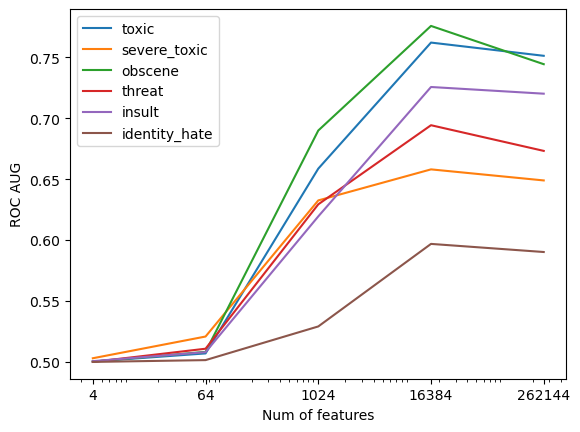

In [11]:
plot_part1_tfidf(tfidf_metrics, TF_num_features)

### Part 2 Word2Vec

In [12]:
w2v_metrics = get_metrics(labels, df_train, df_eval, W2V_num_features, w2v) # type: ignore

Finished label toxic with 10 ROCAUG = 0.7446689635634601


Finished label severe_toxic with 10 ROCAUG = 0.5714342392685173


Finished label obscene with 10 ROCAUG = 0.744769248765926


Finished label threat with 10 ROCAUG = 0.5053090834068856


Finished label insult with 10 ROCAUG = 0.6798508898056026


Finished label identity_hate with 10 ROCAUG = 0.5265293420373338


Finished label toxic with 20 ROCAUG = 0.7536582512942859


Finished label severe_toxic with 20 ROCAUG = 0.5863994894148183


Finished label obscene with 20 ROCAUG = 0.7612698339053106


Finished label threat with 20 ROCAUG = 0.5106967288149025


Finished label insult with 20 ROCAUG = 0.689890205076956


Finished label identity_hate with 20 ROCAUG = 0.5348711594503165


Finished label toxic with 30 ROCAUG = 0.7573927348167981


Finished label severe_toxic with 30 ROCAUG = 0.589554023833921


Finished label obscene with 30 ROCAUG = 0.7666760381103183


Finished label threat with 30 ROCAUG = 0.5324987088505901


Finished label insult with 30 ROCAUG = 0.6912810517339475


Finished label identity_hate with 30 ROCAUG = 0.5364224935806864


Finished label toxic with 40 ROCAUG = 0.7594102454025797


Finished label severe_toxic with 40 ROCAUG = 0.5910600479303065


Finished label obscene with 40 ROCAUG = 0.7684670828864375


Finished label threat with 40 ROCAUG = 0.5542221268851465


Finished label insult with 40 ROCAUG = 0.6918199470192085


Finished label identity_hate with 40 ROCAUG = 0.5481990895782952


Finished label toxic with 50 ROCAUG = 0.7624509822364391


Finished label severe_toxic with 50 ROCAUG = 0.600080360705694


Finished label obscene with 50 ROCAUG = 0.7738732870914451


Finished label threat with 50 ROCAUG = 0.5488030566766771


Finished label insult with 50 ROCAUG = 0.6987305718603265


Finished label identity_hate with 50 ROCAUG = 0.5515547942762818


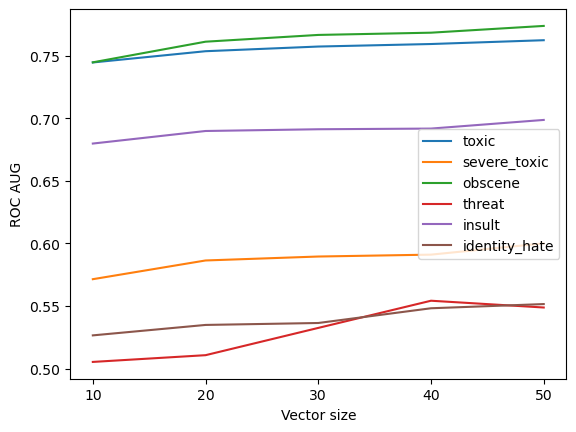

In [14]:
plot_part2_w2v(w2v_metrics, W2V_num_features)

### Comparison

In [38]:
def plot_comparison(w2v_data: dict, tfidf_data: dict, size_generator=W2V_num_features):
    vector_size = [i for i in size_generator()]
    for label in w2v_data.keys():
        plt.plot(vector_size, w2v_data[label])
        plt.plot(vector_size, tfidf_data[label])
        plt.legend([label+"_w2v", label+"_tfidf"])
        plt.xlabel('Vector size')
        plt.ylabel('ROC AUG')
        plt.xscale("log")
        plt.xticks(vector_size,vector_size)
        plt.show()
        
def plot_comparison_1(w2v_data: dict, tfidf_data: dict, 
                      w2v_size_generator = W2V_num_features, 
                      tfidf_size_generator = TF_num_features):
    w2v_vector_size = [i for i in w2v_size_generator()]
    tfidf_vector_size = [i for i in tfidf_size_generator()]
    for label in w2v_data.keys():
        fig, ax1 = plt.subplots()
    
        ax1.plot(tfidf_vector_size, tfidf_data[label], 'b-', label=label+"_tfidf")
        ax1.set_xlabel('tfidf Vector size', color='b')
        ax1.set_xscale("log")
        ax1.set_xticks(tfidf_vector_size,tfidf_vector_size)
        ax1.tick_params("x", colors="r")
        # Make the y-axis label, ticks and tick labels match the line color.
        ax1.set_ylabel('ROC AUG')
        ax1.tick_params('x', colors='b')
        
        ax2 = ax1.twiny()
        ax2.plot(w2v_vector_size, w2v_data[label], 'r-', label=label+"_w2v")
        ax2.set_xlabel('w2v Vector size', color='r')
        ax2.tick_params('x', colors='r')
        fig.legend(loc="right")

        # fig.tight_layout()
        plt.show()

In [19]:
tfidf_metrics_compare = get_metrics(labels, df_train, df_eval, W2V_num_features, tfidf)

Finished label toxic with 10 ROCAUG = 0.5041564435479726


Finished label severe_toxic with 10 ROCAUG = 0.5105105050688474


Finished label obscene with 10 ROCAUG = 0.5037317825700033


Finished label threat with 10 ROCAUG = 0.5054190702084694


Finished label insult with 10 ROCAUG = 0.5031063923295543


Finished label identity_hate with 10 ROCAUG = 0.49996837044534415


22/12/23 02:18:38 WARN MemoryStore: Not enough space to cache rdd_7734_0 in memory! (computed 17.0 MiB so far)
22/12/23 02:18:38 WARN BlockManager: Persisting block rdd_7734_0 to disk instead.


Finished label toxic with 20 ROCAUG = 0.5049484208998328


22/12/23 02:19:00 WARN MemoryStore: Not enough space to cache rdd_7822_0 in memory! (computed 17.0 MiB so far)
22/12/23 02:19:00 WARN BlockManager: Persisting block rdd_7822_0 to disk instead.


Finished label severe_toxic with 20 ROCAUG = 0.5149652501463011


22/12/23 02:19:23 WARN MemoryStore: Not enough space to cache rdd_7934_0 in memory! (computed 17.0 MiB so far)
22/12/23 02:19:23 WARN BlockManager: Persisting block rdd_7934_0 to disk instead.


Finished label obscene with 20 ROCAUG = 0.5052077849451113


22/12/23 02:19:45 WARN MemoryStore: Not enough space to cache rdd_8029_0 in memory! (computed 17.0 MiB so far)
22/12/23 02:19:45 WARN BlockManager: Persisting block rdd_8029_0 to disk instead.


Finished label threat with 20 ROCAUG = 0.505387645408017


22/12/23 02:20:09 WARN MemoryStore: Not enough space to cache rdd_8156_0 in memory! (computed 17.0 MiB so far)
22/12/23 02:20:09 WARN BlockManager: Persisting block rdd_8156_0 to disk instead.


Finished label insult with 20 ROCAUG = 0.5046678268123964


22/12/23 02:20:31 WARN MemoryStore: Not enough space to cache rdd_8249_0 in memory! (computed 17.0 MiB so far)
22/12/23 02:20:31 WARN BlockManager: Persisting block rdd_8249_0 to disk instead.


Finished label identity_hate with 20 ROCAUG = 0.5033240751433308


22/12/23 02:21:02 WARN MemoryStore: Not enough space to cache rdd_8370_0 in memory! (computed 17.0 MiB so far)
22/12/23 02:21:02 WARN BlockManager: Persisting block rdd_8370_0 to disk instead.


Finished label toxic with 30 ROCAUG = 0.5055669377139653


22/12/23 02:21:24 WARN MemoryStore: Not enough space to cache rdd_8459_0 in memory! (computed 17.0 MiB so far)
22/12/23 02:21:24 WARN BlockManager: Persisting block rdd_8459_0 to disk instead.


Finished label severe_toxic with 30 ROCAUG = 0.5134275624440641


22/12/23 02:21:47 WARN MemoryStore: Not enough space to cache rdd_8578_0 in memory! (computed 17.0 MiB so far)
22/12/23 02:21:47 WARN BlockManager: Persisting block rdd_8578_0 to disk instead.


Finished label obscene with 30 ROCAUG = 0.5057221251788612


22/12/23 02:22:10 WARN MemoryStore: Not enough space to cache rdd_8677_0 in memory! (computed 17.0 MiB so far)
22/12/23 02:22:10 WARN BlockManager: Persisting block rdd_8677_0 to disk instead.


Finished label threat with 30 ROCAUG = 0.505387645408017


22/12/23 02:22:34 WARN MemoryStore: Not enough space to cache rdd_8820_0 in memory! (computed 17.0 MiB so far)
22/12/23 02:22:34 WARN BlockManager: Persisting block rdd_8820_0 to disk instead.


Finished label insult with 30 ROCAUG = 0.5061798313868485


22/12/23 02:22:57 WARN MemoryStore: Not enough space to cache rdd_8918_0 in memory! (computed 17.0 MiB so far)
22/12/23 02:22:57 WARN BlockManager: Persisting block rdd_8918_0 to disk instead.


Finished label identity_hate with 30 ROCAUG = 0.4999051113360324


22/12/23 02:23:28 WARN MemoryStore: Not enough space to cache rdd_9043_0 in memory! (computed 17.0 MiB so far)
22/12/23 02:23:28 WARN BlockManager: Persisting block rdd_9043_0 to disk instead.


Finished label toxic with 40 ROCAUG = 0.5066132602129876


22/12/23 02:23:50 WARN MemoryStore: Not enough space to cache rdd_9141_0 in memory! (computed 17.0 MiB so far)
22/12/23 02:23:50 WARN BlockManager: Persisting block rdd_9141_0 to disk instead.


Finished label severe_toxic with 40 ROCAUG = 0.5210051783347691


22/12/23 02:24:15 WARN MemoryStore: Not enough space to cache rdd_9275_0 in memory! (computed 17.0 MiB so far)
22/12/23 02:24:15 WARN BlockManager: Persisting block rdd_9275_0 to disk instead.


Finished label obscene with 40 ROCAUG = 0.5086575949907527


22/12/23 02:24:38 WARN MemoryStore: Not enough space to cache rdd_9381_0 in memory! (computed 17.0 MiB so far)
22/12/23 02:24:38 WARN BlockManager: Persisting block rdd_9381_0 to disk instead.


Finished label threat with 40 ROCAUG = 0.5053562206075644


22/12/23 02:25:02 WARN MemoryStore: Not enough space to cache rdd_9511_0 in memory! (computed 17.0 MiB so far)
22/12/23 02:25:02 WARN BlockManager: Persisting block rdd_9511_0 to disk instead.


Finished label insult with 40 ROCAUG = 0.5055255996486778


22/12/23 02:25:25 WARN MemoryStore: Not enough space to cache rdd_9615_0 in memory! (computed 17.0 MiB so far)
22/12/23 02:25:25 WARN BlockManager: Persisting block rdd_9615_0 to disk instead.


Finished label identity_hate with 40 ROCAUG = 0.5066007059546775


22/12/23 02:25:57 WARN MemoryStore: Not enough space to cache rdd_9752_0 in memory! (computed 17.0 MiB so far)
22/12/23 02:25:57 WARN BlockManager: Persisting block rdd_9752_0 to disk instead.


Finished label toxic with 50 ROCAUG = 0.5069196435214679


22/12/23 02:26:21 WARN MemoryStore: Not enough space to cache rdd_9858_0 in memory! (computed 17.0 MiB so far)
22/12/23 02:26:21 WARN BlockManager: Persisting block rdd_9858_0 to disk instead.


Finished label severe_toxic with 50 ROCAUG = 0.5194516588296063


22/12/23 02:26:46 WARN MemoryStore: Not enough space to cache rdd_10001_0 in memory! (computed 17.0 MiB so far)
22/12/23 02:26:46 WARN BlockManager: Persisting block rdd_10001_0 to disk instead.


Finished label obscene with 50 ROCAUG = 0.5073478205717338


22/12/23 02:27:10 WARN MemoryStore: Not enough space to cache rdd_10111_0 in memory! (computed 17.0 MiB so far)
22/12/23 02:27:10 WARN BlockManager: Persisting block rdd_10111_0 to disk instead.


Finished label threat with 50 ROCAUG = 0.5107595784158075


22/12/23 02:27:35 WARN MemoryStore: Not enough space to cache rdd_10260_0 in memory! (computed 17.0 MiB so far)
22/12/23 02:27:35 WARN BlockManager: Persisting block rdd_10260_0 to disk instead.


Finished label insult with 50 ROCAUG = 0.5068670163972793


22/12/23 02:28:00 WARN MemoryStore: Not enough space to cache rdd_10374_0 in memory! (computed 17.0 MiB so far)
22/12/23 02:28:00 WARN BlockManager: Persisting block rdd_10374_0 to disk instead.


Finished label identity_hate with 50 ROCAUG = 0.5014880750210581


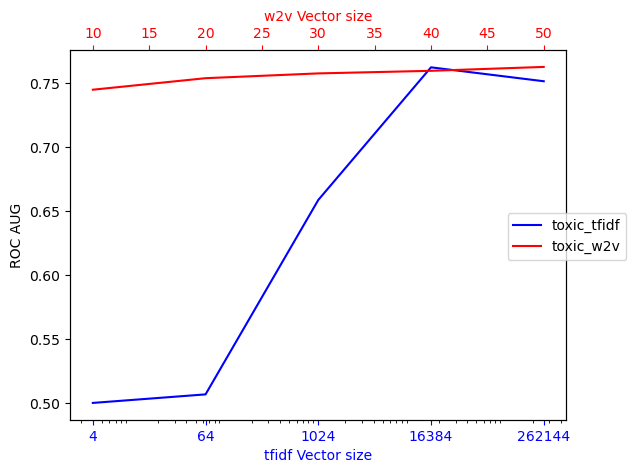

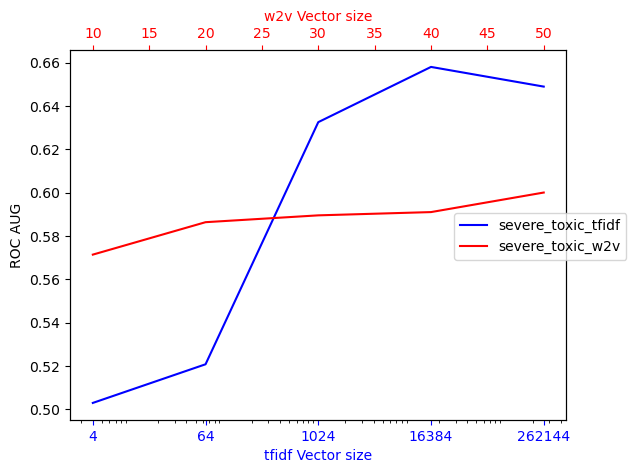

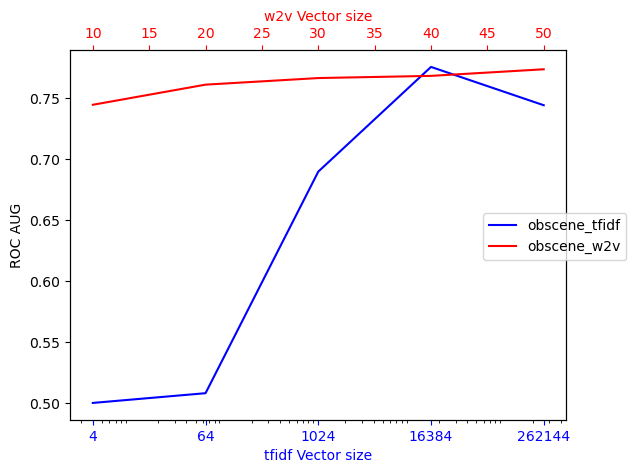

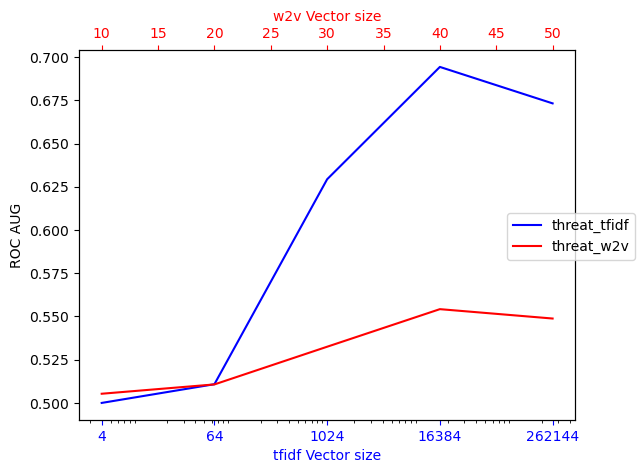

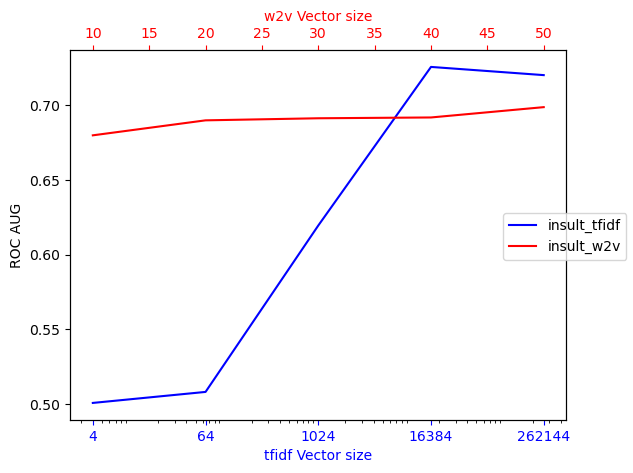

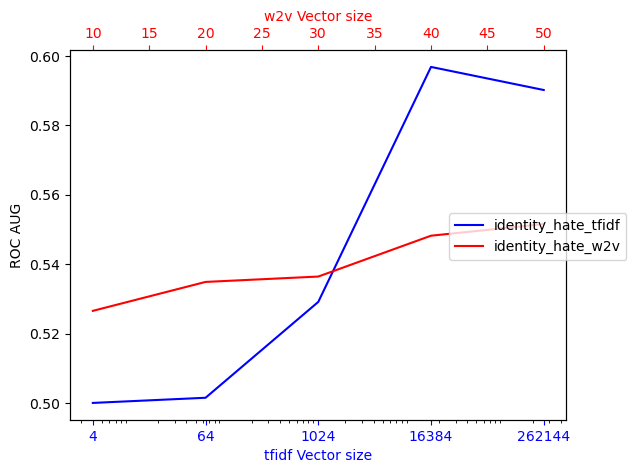

In [39]:
plot_comparison_1(w2v_metrics, tfidf_metrics)

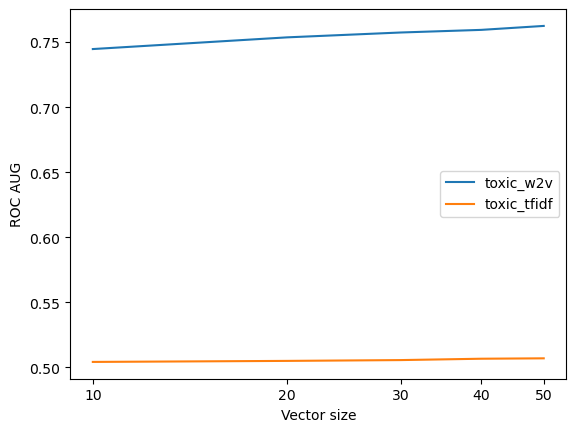

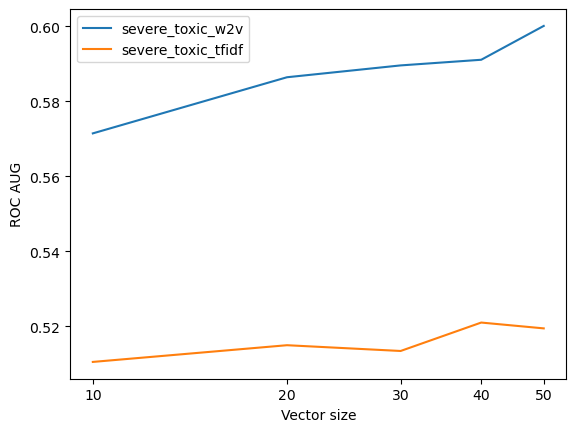

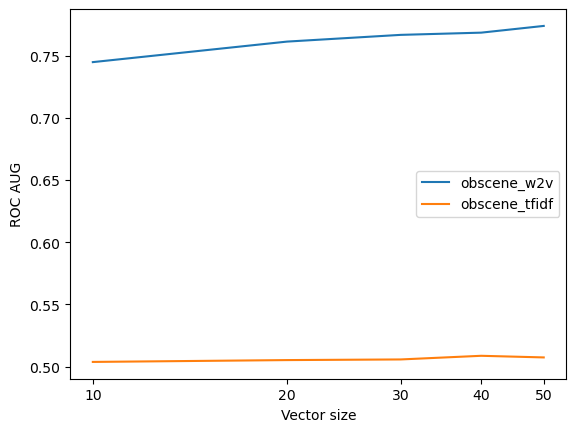

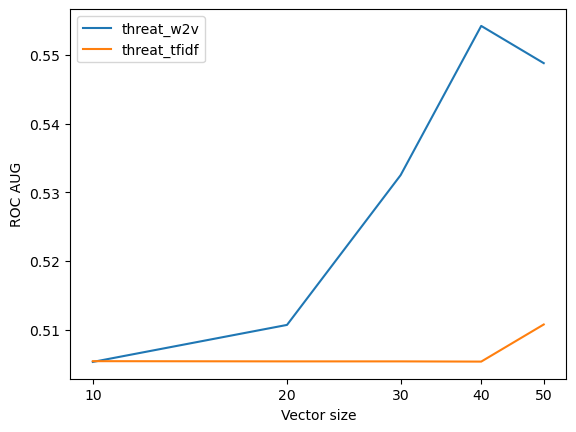

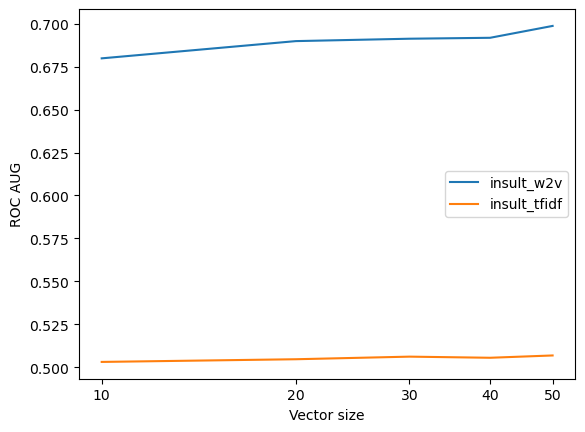

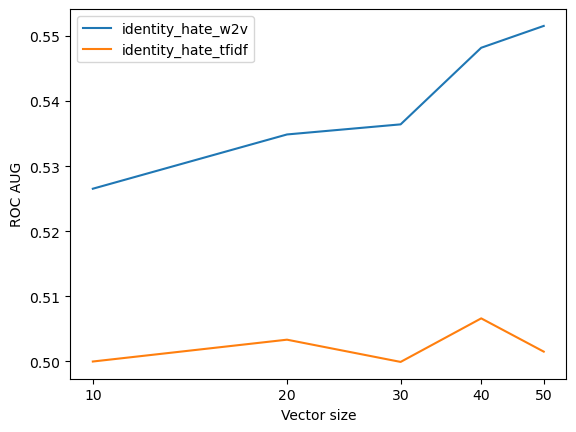

In [22]:
plot_comparison(w2v_metrics, tfidf_metrics_compare, W2V_num_features)